# **Analyse du DataSet**


## **Télécharger les données**

In [1]:
from google.colab import drive
import os
import random
import shutil

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_to_dataset = '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre'

In [3]:
def set_category(path_to_dataset):
  return os.listdir(path_to_dataset)

In [4]:
def load_category(path_to_dataset,category):
  return f"{path_to_dataset}/{category}"

In [5]:
print(load_category(path_to_dataset,"Academic_Art"))

/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Academic_Art


In [6]:
categories = set_category(path_to_dataset)
path_to_categories = []

for category in categories:
  path_to_categories.append(load_category(path_to_dataset,category))

print(path_to_categories)

['/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Academic_Art', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Expressionism', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Art_Nouveau', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Baroque', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Western_Medieval', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Symbolism', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Romanticism', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Rococo', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Realism', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Primitivism', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Neoclassicism', '/content/drive/Shareddrives/Classifiaction IA/dataset_equilibre/Japanese_Art', '/content/drive/Shareddrives/Classifiaction IA/dataset_

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence

In [8]:
# Paramètres globaux
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

# Fonction pour charger et prétraiter une image
def load_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisation
    return img_array

# Préparer les chemins et les labels
def prepare_data(path_to_categories):
    image_paths = []
    labels = []
    class_names = [os.path.basename(cat_path) for cat_path in path_to_categories]

    for label, category_path in enumerate(path_to_categories):
        images = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith(('png', 'jpg', 'jpeg'))]
        image_paths.extend(images)
        labels.extend([label] * len(images))

    return image_paths, labels, class_names

image_paths, labels, class_names = prepare_data(path_to_categories)
print(f"Classes disponibles : {class_names}")
print(f"Nombre total d'images : {len(image_paths)}")

Classes disponibles : ['Academic_Art', 'Expressionism', 'Art_Nouveau', 'Baroque', 'Western_Medieval', 'Symbolism', 'Romanticism', 'Rococo', 'Realism', 'Primitivism', 'Neoclassicism', 'Japanese_Art', 'Renaissance']
Nombre total d'images : 13538


## **DataGenerator création**

In [9]:
# Création d'un data generator personnalisé avec super().__init__()
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_image_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        images = np.array([load_image(img_path) for img_path in batch_image_paths])
        labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(set(self.labels)))
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)


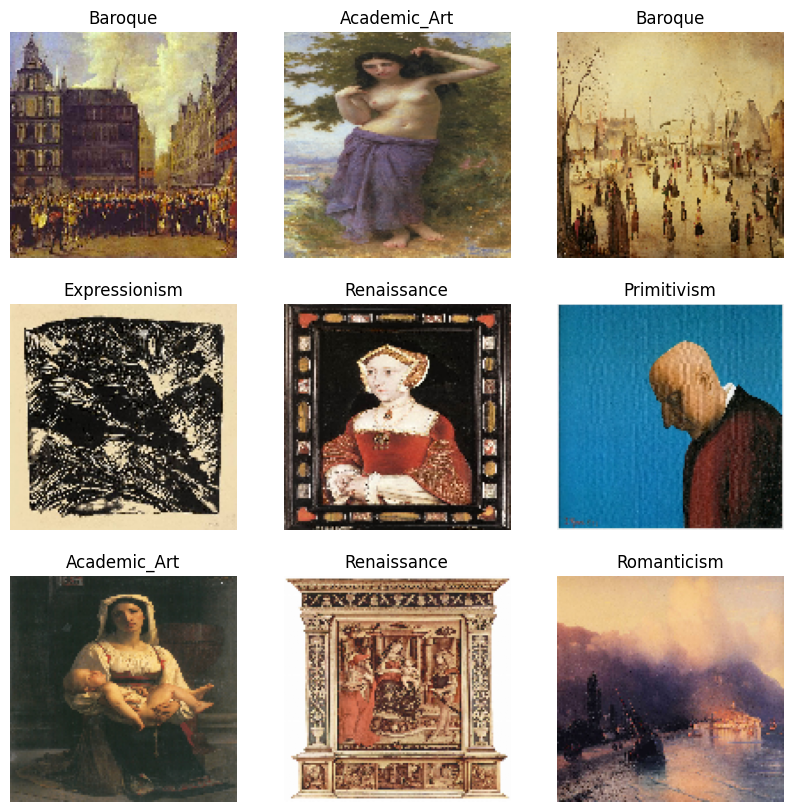

In [10]:
# Séparer les données en ensembles d'entraînement et de validation
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=123, stratify=labels
)

# Instancier les générateurs
generator_train = CustomDataGenerator(train_paths, train_labels, BATCH_SIZE)
generator_val = CustomDataGenerator(val_paths, val_labels, BATCH_SIZE)

# Exemple de visualisation
import matplotlib.pyplot as plt

for images, labels in generator_train:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


# **Création du modèle**

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Gèle les poids du modèle pré-entraîné

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
val_loss, val_accuracy = model.evaluate(generator_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

 28/170 ━━━━━━━━━━━━━━━━━━━━ 41:33 18s/step - accuracy: 0.0877 - loss: 3.0017

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
num_batches = 150  # Nombre maximum de lots à tester

for i, (images, labels) in enumerate(generator_val):
    if i >= num_batches:
        break
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

plt.figure(figsize=(12, 8))
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()
